In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import Levenshtein
from pathlib import Path
import pickle as pk
import numpy as np
import pickle as pk

from src.analysis.fraudulous import filter_out, detect_honey_frauders, detect_repeat_frauders,study_outsiders
from src.constants import HONEYPOTS, EMOJI_DATASET_DIR, HONEYPOTS, EM_VOC_COUNT, EMOJI_DATASET_EXPORT_DIR
from src.analysis.postprocessing import (scrap_form_results, get_emojis_voc_counts, write_emojis_voc_counts,
                                         display_whole_dir, generate_production_format, build_worker_info_table)
from src.analysis.spelling import WordSuggester
import matplotlib.pyplot as plt

In [3]:
# create the worker infos table
worker_infos = build_worker_info_table(input_directory=EMOJI_DATASET_DIR,
                                       output_dir=EMOJI_DATASET_EXPORT_DIR)

# Postprocessing

<div class="alert alert-success">
Postprocessing of data gathered from mturk/gform
</div>

## Frauder Detection

In [4]:
# List of all df in child directories of dataset dir
form_dfs = scrap_form_results(EMOJI_DATASET_DIR)

N = sum([df.shape[0] for df in form_dfs])
print(f"Initial data shape: {N} rows")

100%|██████████| 133/133 [00:54<00:00,  2.45it/s]

Initial data shape: 4042 rows


#### Repeat frauders

In [5]:
n_frauders, form_dfs = filter_out(
    form_dfs, detect_repeat_frauders, 0.8, verbose=True, display_=False)

Discarded 1 rows


#### Honeypots frauders

In [6]:
honeypots = HONEYPOTS
dist_lshtein = 2

# Uncomment the cell to check for refused honeypots words
# study_outsiders(form_dfs,HONEYPOTS,dist_lshtein)

n_honey, form_dfs = filter_out(
    form_dfs, detect_honey_frauders, HONEYPOTS, dist_lshtein=dist_lshtein, verbose=True)

Discarded 433 rows


## Visualizing the vocabulary 

<div class="alert alert-success">
We compute the value counts of every word for each emoji and save it to a file.
</div>

In [7]:
em2vocab = get_emojis_voc_counts(EMOJI_DATASET_DIR)
write_emojis_voc_counts(em2vocab, EM_VOC_COUNT)

## Generating final format

In [94]:
tot_df = generate_production_format(form_dfs, EMOJI_DATASET_EXPORT_DIR)

100%|██████████| 133/133 [00:02<00:00, 45.67it/s]


### Correcting misspelled words

In [95]:
sugg = WordSuggester()
sugg.correct_prod_df(tot_df,debug=True)

Initializing the vocabulary set..
Initializing BERT pipeline..


 10%|█         | 3/30 [00:00<00:01, 13.91it/s]

Modified:  astrik --> astrid (corrected)
Modified:  asterik --> asterisk (cross_suggested)
Modified:  coppyright --> copyright (cross_suggested)
Modified:  cee --> cen (corrected)


100%|██████████| 30/30 [00:00<00:00, 66.13it/s]

Modified:  circler --> circle r (disassembled2)
Modified:  capitalr --> capital r (disassembled2)
Modified:  excalmation --> exclamation (cross_suggested)
Modified:  exclamationquestion --> exclamation question (disassembled1)
Modified:  leftright --> left right (disassembled1)
Modified:  leftorright --> left or right (disassembled1)
Modified:  whichway --> which way (disassembled1)
Modified:  upanddown --> up and down (disassembled1)
Modified:  upleftarrow --> up left arrow (disassembled1)
Modified:  risingsign --> rising sign (disassembled1)
Modified:  thatway --> that way (disassembled1)
Modified:  arrowbottomleftcorner --> arrow bottom left corner (disassembled1)
Modified:  sandglass --> sand glass (disassembled1)
Modified:  playandstop --> play and stop (disassembled1)
Nof found:  fastfoward
Modified:  backtotop --> back to top (disassembled1)
Modified:  uparrow --> up arrow (disassembled2)
Modified:  foward --> forward (cross_suggested)
Modified:  downvote --> down vote (disassem

## Plotting Statistics

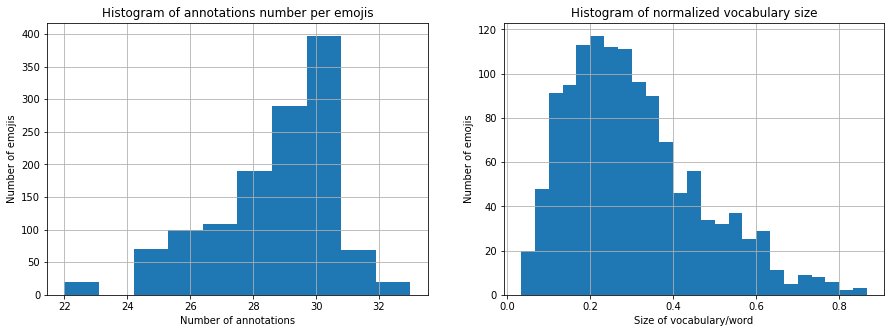

In [26]:
def plot_hist_num_anot_per_emoji(tot_df):
    """
    """
    fig,axes = plt.subplots(1,2,figsize=(15,5))
    
    ax = axes[0]
    val_counts = tot_df['emoji'].value_counts()
    val_counts.hist(ax=ax)
    ax.set_xlabel("Number of annotations")
    ax.set_ylabel("Number of emojis")
    ax.set_title("Histogram of annotations number per emojis")
    
    ax = axes[1]
    voc_size_per_emoji = tot_df.groupby('emoji')['word'].agg(lambda x: len(set(x)))
    voc_size_per_emoji = voc_size_per_emoji / val_counts
    voc_size_per_emoji.hist(ax=ax,bins=25)
    ax.set_xlabel('Size of vocabulary/word')
    ax.set_ylabel('Number of emojis')
    ax.set_title('Histogram of normalized vocabulary size')

plot_hist_num_anot_per_emoji(tot_df)